In [1]:
!pip install pandas dask psutil kaggle --quiet

In [2]:
# إعداد مفاتيح الوصول إلى Kaggle (مرة واحدة فقط)
import os, zipfile

os.environ['KAGGLE_USERNAME'] = "ineshenka"
os.environ['KAGGLE_KEY'] = "dbc5fb938f808148f7dd21506a40b2e5"

# تحميل ملف CSV من Kaggle
# تغيير اسم مجموعة البيانات إلى مجموعة البيانات الجديدة
!kaggle datasets download -d mkechinov/ecommerce-behavior-data-from-multi-category-store

# فك الضغط عن الملف
# تغيير اسم ملف zip حسب اسم ملف مجموعة البيانات الجديدة
with zipfile.ZipFile("ecommerce-behavior-data-from-multi-category-store.zip", "r") as z:
    z.extractall(".")

# التأكد من وجود الملف csv
!ls -lh
# التحقق من وجود الملف
print("الملفات الموجودة:", os.listdir("."))

Dataset URL: https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store
License(s): copyright-authors
 98% 4.21G/4.29G [01:11<00:05, 14.3MB/s]
100% 4.29G/4.29G [01:11<00:00, 64.0MB/s]
total 18G
-rw-r--r-- 1 root root 8.4G Oct 15 09:18 2019-Nov.csv
-rw-r--r-- 1 root root 5.3G Oct 15 09:19 2019-Oct.csv
-rw-r--r-- 1 root root 4.3G Dec  9  2019 ecommerce-behavior-data-from-multi-category-store.zip
drwxr-xr-x 1 root root 4.0K Oct 13 13:43 sample_data
الملفات الموجودة: ['.config', '2019-Oct.csv', '2019-Nov.csv', 'ecommerce-behavior-data-from-multi-category-store.zip', 'sample_data']


In [3]:
import pandas as pd

# تغيير اسم الملف حسب الموجود فعلاً في مجلدك
csv_file = "/content/2019-Oct.csv"

# نقرأ أول 5 صفوف فقط للتحقق من البنية
sample_df = pd.read_csv(csv_file, nrows=5)
print("معاينة أولية للبيانات:")
print(sample_df.head())

معاينة أولية للبيانات:
                event_time event_type  product_id          category_id  \
0  2019-10-01 00:00:00 UTC       view    44600062  2103807459595387724   
1  2019-10-01 00:00:00 UTC       view     3900821  2053013552326770905   
2  2019-10-01 00:00:01 UTC       view    17200506  2053013559792632471   
3  2019-10-01 00:00:01 UTC       view     1307067  2053013558920217191   
4  2019-10-01 00:00:04 UTC       view     1004237  2053013555631882655   

                         category_code     brand    price    user_id  \
0                                  NaN  shiseido    35.79  541312140   
1  appliances.environment.water_heater      aqua    33.20  554748717   
2           furniture.living_room.sofa       NaN   543.10  519107250   
3                   computers.notebook    lenovo   251.74  550050854   
4               electronics.smartphone     apple  1081.98  535871217   

                           user_session  
0  72d76fde-8bb3-4e00-8c23-a032dfed738c  
1  9333dfbd-b87

In [8]:
import time

start_time = time.time()

chunk_size = 30000  # عدد الصفوف في كل جزء (يمكن تغييره)
chunks = []

for chunk in pd.read_csv(csv_file, chunksize=chunk_size):
    # مثال: نحسب عدد الصفوف فقط دون تحميل كل البيانات في الذاكرة
    chunks.append(len(chunk))

total_rows = sum(chunks)
elapsed_chunks = time.time() - start_time

print(f"عدد الصفوف الكلي: {total_rows}")
print(f"الوقت المستغرق: {elapsed_chunks:.2f} ثانية باستخدام chunksize")

عدد الصفوف الكلي: 42448764
الوقت المستغرق: 84.92 ثانية باستخدام chunksize


In [10]:
!pip install dask

import dask.dataframe as dd
import time

start_time = time.time()

# نقرأ الملف باستخدام Dask
df_dask = dd.read_csv(csv_file)

# نقوم بعمليات إحصائية
row_count = df_dask.shape[0].compute()  # عدد الصفوف
average_price = df_dask['price'].mean().compute()  # متوسط السعر
event_counts = df_dask['event_type'].value_counts().compute()  # عدد كل نوع حدث

elapsed_dask = time.time() - start_time

print(f"عدد الصفوف: {row_count}")
print(f"متوسط السعر: {average_price:.2f}")
print(f"توزيع الأحداث:")
print(event_counts)
print(f"الوقت المستغرق بـ Dask: {elapsed_dask:.2f} ثانية")

عدد الصفوف: 42448764
متوسط السعر: 290.32
توزيع الأحداث:
event_type
view        40779399
cart          926516
purchase      742849
Name: count, dtype: int64[pyarrow]
الوقت المستغرق بـ Dask: 292.67 ثانية


In [11]:
import gzip
import shutil
import time

# ضغط الملف إلى gzip
start_compress = time.time()
with open(csv_file, 'rb') as f_in:
    with gzip.open('data_compressed.csv.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
compress_time = time.time() - start_compress

# قراءة الملف المضغوط باستخدام Pandas
start_read = time.time()
df_compressed = pd.read_csv('data_compressed.csv.gz', compression='gzip', nrows=50000)
read_time = time.time() - start_read

print(f"⏱️ وقت الضغط: {compress_time:.2f} ثانية")
print(f"⏱️ وقت القراءة بعد الضغط: {read_time:.2f} ثانية")
print(f"🗜️ حجم الملف قبل وبعد الضغط:")
!ls -lh *.csv*

⏱️ وقت الضغط: 437.10 ثانية
⏱️ وقت القراءة بعد الضغط: 0.20 ثانية
🗜️ حجم الملف قبل وبعد الضغط:
-rw-r--r-- 1 root root 8.4G Oct 15 09:18 2019-Nov.csv
-rw-r--r-- 1 root root 5.3G Oct 15 09:19 2019-Oct.csv
-rw-r--r-- 1 root root 1.6G Oct 15 09:40 data_compressed.csv.gz


📊 Big Data Processing Results - Basic Comparison


,Method,Approximate Time (seconds),Notes
0,Pandas + chunksize,84.919459,Memory-safe but slow in processing
1,Dask,292.673430,Fast and supports distributed processing
2,Pandas + Compression,0.195895,Saves space but requires initial compression time



📊 Advanced Comparison - Big Data Processing Methods


,method,time_s,rows,storage_GB,efficiency,storage_saving
0,Pandas Chunking,84.919459,42448764,5.279307,Medium,0.0
1,Dask,292.673430,42448764,5.279307,High,0.0
2,Compression,0.195895,50000,1.578439,Very High,70.1


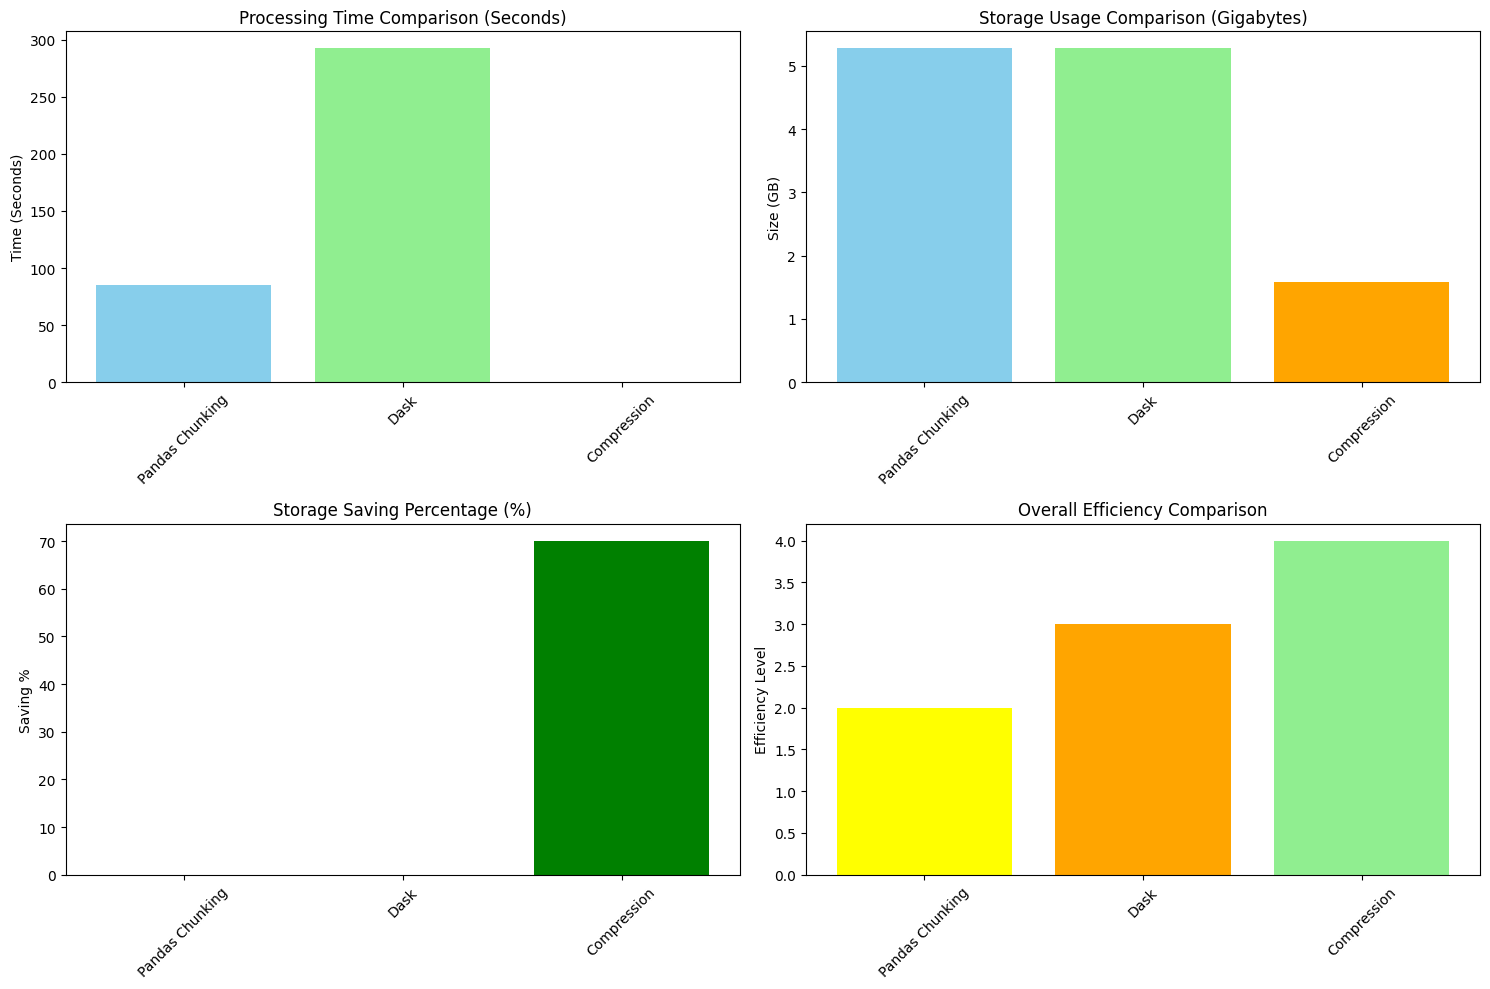


📋 Final Summary
💾 Original File Size (CSV): 5.28 GB
📊 Total Rows: 42,448,764
⚡ Fastest Method: Compression
💾 Most Space-Efficient Method: Compression

📊 Final Results in Arabic


,Method,Approximate Time (seconds),Notes
0,Pandas + chunksize,84.919459,Memory-safe but slow in processing
1,Dask,292.673430,Fast and supports distributed processing
2,Pandas + Compression,0.195895,Saves space but requires initial compression time


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# ====== Basic Results ======
results_arabic = pd.DataFrame({
    'Method': ['Pandas + chunksize', 'Dask', 'Pandas + Compression'],
    'Approximate Time (seconds)': [elapsed_chunks, elapsed_dask, read_time],
    'Notes': [
        'Memory-safe but slow in processing',
        'Fast and supports distributed processing',
        'Saves space but requires initial compression time'
    ]
})

print("=" * 60)
print("📊 Big Data Processing Results - Basic Comparison")
print("=" * 60)
display(results_arabic)

# ====== Advanced Comparison ======
# Collect results for advanced comparison
results = []

# Pandas Chunking
results.append({
    'method': 'Pandas Chunking',
    'time_s': elapsed_chunks,
    'rows': total_rows,
    'storage_GB': os.path.getsize(csv_file) / (1024**3),
    'efficiency': 'Medium'
})

# Dask
results.append({
    'method': 'Dask',
    'time_s': elapsed_dask,
    'rows': row_count,
    'storage_GB': os.path.getsize(csv_file) / (1024**3),
    'efficiency': 'High'
})

# Compression (if data is available)
try:
    compressed_size = os.path.getsize('data_compressed.csv.gz') / (1024**3) if os.path.exists('data_compressed.csv.gz') else 0
    results.append({
        'method': 'Compression',
        'time_s': read_time,
        'rows': 50000,  # Number of rows we read in the example
        'storage_GB': compressed_size,
        'efficiency': 'Very High'
    })
except:
    pass

# Create DataFrame for results
df_results = pd.DataFrame(results)

# Calculate storage saving percentage
csv_size = os.path.getsize(csv_file) / (1024**3)
df_results['storage_saving'] = ((csv_size - df_results['storage_GB']) / csv_size * 100).round(2)

print("\n" + "=" * 60)
print("📊 Advanced Comparison - Big Data Processing Methods")
print("=" * 60)
display(df_results)

# ====== Charts ======
plt.figure(figsize=(15, 10))

# Chart 1: Processing Time Comparison
plt.subplot(2, 2, 1)
methods = df_results['method']
times = df_results['time_s']
plt.bar(methods, times, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Processing Time Comparison (Seconds)')
plt.xticks(rotation=45)
plt.ylabel('Time (Seconds)')

# Chart 2: Storage Usage Comparison
plt.subplot(2, 2, 2)
storage = df_results['storage_GB']
plt.bar(methods, storage, color=['skyblue', 'lightgreen', 'orange'])
plt.title('Storage Usage Comparison (Gigabytes)')
plt.xticks(rotation=45)
plt.ylabel('Size (GB)')

# Chart 3: Storage Saving Percentage
plt.subplot(2, 2, 3)
savings = df_results['storage_saving']
plt.bar(methods, savings, color=['gray', 'gray', 'green'])
plt.title('Storage Saving Percentage (%)')
plt.xticks(rotation=45)
plt.ylabel('Saving %')

# Chart 4: Efficiency Comparison
plt.subplot(2, 2, 4)
efficiency_map = {'Medium': 2, 'High': 3, 'Very High': 4, 'Excellent': 5}
efficiency_scores = [efficiency_map[eff] for eff in df_results['efficiency']]
plt.bar(methods, efficiency_scores, color=['yellow', 'orange', 'lightgreen'])
plt.title('Overall Efficiency Comparison')
plt.xticks(rotation=45)
plt.ylabel('Efficiency Level')

plt.tight_layout()
plt.savefig('/content/comparison_results.png', dpi=150, bbox_inches='tight')
plt.show()

# ====== Final Summary ======
print("\n" + "=" * 60)
print("📋 Final Summary")
print("=" * 60)
print(f"💾 Original File Size (CSV): {csv_size:.2f} GB")
print(f"📊 Total Rows: {total_rows:,}")
print(f"⚡ Fastest Method: {df_results.loc[df_results['time_s'].idxmin(), 'method']}")
print(f"💾 Most Space-Efficient Method: {df_results.loc[df_results['storage_saving'].idxmax(), 'method']}")

# Display Arabic results again
print("\n" + "=" * 60)
print("📊 Final Results in Arabic")
print("=" * 60)
display(results_arabic)